# Shopping QnA

- Author: [Mark](https://github.com/obov)
- Design: []()
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb)

## Overview

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Data Augmentation](#data-augmentation)
- [Storing embedded values in VectorDB](#storing-embedded-values-in-vectordb)
- [Vector Search](#vector-search)
- [Multimodal RAG Chatbot](#multimodal-rag-chatbot)

### References

- [Bedrock Multimodal RAG Chatbot](https://aws.amazon.com/ko/blogs/tech/bedrock-multimodal-rag-chatbot/)
- [Public Multimodal RAG Chatbot](https://github.com/hi-space/public-multimodal-rag-chatbot/tree/main)
- [Kream Product BLIP Captions](https://huggingface.co/datasets/hahminlew/kream-product-blip-captions)
- [LangChain Multimodal Inputs](https://python.langchain.com/docs/how_to/multimodal_inputs/)

---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "datasets",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_experimental",
        "langchain_chroma",
        "open_clip_torch",
        "torch",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "Your API KEY",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "06-MultiModal/11-ShoppingQnA",
    }
)

Environment variables have been set successfully.


In [4]:
# Alternatively, one can set environmental variables with load_dotenv
from dotenv import load_dotenv


load_dotenv(override=True)

True

## Data Augmentation

To generate a dataset suitable for a virtual shopping mall’s product database using the KREAM Product BLIP Captions dataset, we need to perform data augmentation.


In [5]:
from datasets import load_dataset
import os

# Serialize dictionary to pickle file

os.makedirs("../data", exist_ok=True)
os.makedirs("../data/11-ShoppingQnA-cache", exist_ok=True)

# Load dataset
dataset = load_dataset(
    "hahminlew/kream-product-blip-captions", cache_dir="../data/11-ShoppingQnA-cache"
)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 14904
    })
})


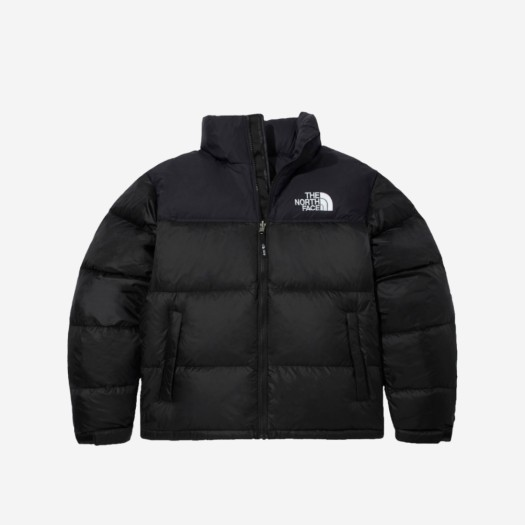

outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket


In [6]:
from IPython.display import display

display(dataset["train"][0]["image"])
print(dataset["train"][0]["text"])

Dataset({
    features: ['image', 'text'],
    num_rows: 200
})
200


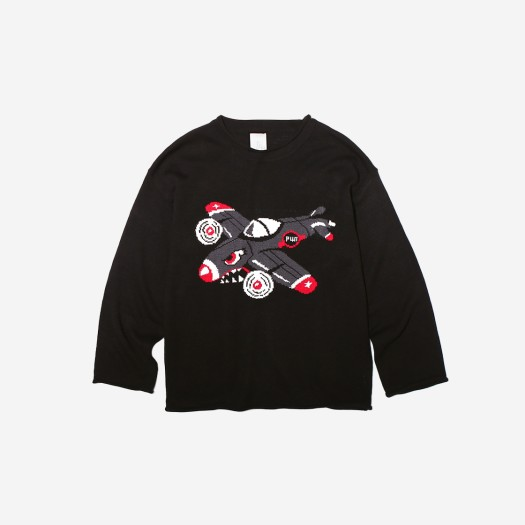

top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif


In [7]:
# Sample Size
SAMPLE_SIZE = 200

# Randomly sampling
sampled_dataset = dataset["train"].shuffle(seed=42).select(range(SAMPLE_SIZE))

print(sampled_dataset)
print(len(sampled_dataset))
display(sampled_dataset[0]["image"])
print(sampled_dataset[0]["text"])

{'resized_image': <PIL.Image.Image image mode=RGB size=262x262 at 0x17707C490>, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=525x525 at 0x1770CFB10>, 'text': 'top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif'}


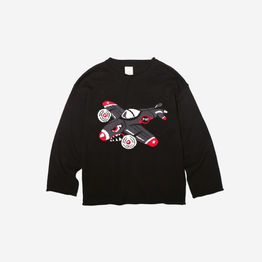

In [8]:
from PIL import Image


def resize_image(image, scale_factor):
    """
    이미지의 해상도를 원하는 비율로 줄이는 함수.

    Args:
        image (PIL.Image.Image): PIL 이미지 객체.
        scale_factor (float): 해상도를 줄이는 비율 (0 ~ 1).

    Returns:
        PIL.Image.Image: 해상도가 줄어든 PIL 이미지 객체.
    """
    if not (0 < scale_factor <= 1):
        raise ValueError("scale_factor는 0보다 크고 1 이하이어야 합니다.")

    # get original size
    original_width, original_height = image.size

    # calculate new size
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    # resize image
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return resized_image


image_resized_dataset = [
    {"resized_image": resize_image(item["image"], 0.5), **item}
    for item in sampled_dataset
]

print(image_resized_dataset[0])
display(image_resized_dataset[0]["resized_image"])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=525x525 at 0x1770CFB10>, 'resized_image': <PIL.Image.Image image mode=RGB size=262x262 at 0x17707C490>, 'type': 'top', 'name': '  P40 Knit Black', 'summary': ' a photography of a black long sleeved shirt with a motorcycle motif'}


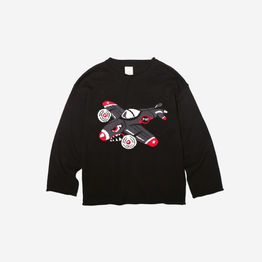

In [9]:
def sample_item_process(item):
    splited = item["text"].split(",")
    return {
        "image": item["image"],
        "resized_image": item["resized_image"],
        "type": splited[0],
        "name": splited[1],
        "summary": splited[2],
    }


processed_dataset = [sample_item_process(item) for item in image_resized_dataset]
print(processed_dataset[0])
display(processed_dataset[0]["resized_image"])

In [10]:
# Json Data Augmentation

import base64
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from io import BytesIO
import json
from langchain_core.output_parsers import BaseOutputParser


# Create model
llm_multimodal = ChatOpenAI(model_name="gpt-4o")


# PIL Image to Base64
def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def process_item_to_prompt(item):
    image_data = pil_image_to_base64(item["resized_image"])
    item["base64_image"] = image_data
    item["base64_image_url"] = f"data:image/jpeg;base64,{image_data}"
    type = item["type"]
    name = item["name"]

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Look at the image and properties of this product and describe it\n"
                "Format the response as a JSON object with four keys: 'summary', 'image_summary' and 'tags'.\n"
                "- 'summary': Summary of product form based on appearance in a sentence\n"
                "- 'image_summary': Describe this image of product based on its type, color, material, pattern, and features.\n"
                "- 'tags':  An array of strings representing key features or properties that can represent color, pattern, material, type of the product.\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
            {
                "type": "text",
                "text": f"The product is a type of {type} and name is {name}.",
            },
        ],
    )

    return message


class JsonOutputParser(BaseOutputParser[dict]):
    def parse(self, text: str) -> dict:
        text = text[7:-3]
        return json.loads(text)


response = (llm_multimodal | JsonOutputParser()).invoke(
    [process_item_to_prompt(processed_dataset[0])]
)
print(response)


# Use batch to process multiple messages
response = (llm_multimodal | JsonOutputParser()).batch(
    [
        [process_item_to_prompt(processed_dataset[1])],
        [process_item_to_prompt(processed_dataset[2])],
    ]
)
print(response[0])
print(response[1])

{'summary': 'A black knit top featuring an airplane graphic on the front.', 'image_summary': 'This is a black knit sweater with a colorful airplane design. The graphic includes red and white accents and has a playful, cartoonish style. The material appears to be soft knit fabric.', 'tags': ['black', 'knit', 'sweater', 'airplane', 'graphic', 'long-sleeve']}
{'summary': 'The product is a sleeveless, padded gilet with a high collar and button closure.', 'image_summary': 'This is a black, quilted, sleeveless gilet made from a shiny material. It features a high collar, button closure, and two front pockets with flaps. The gilet has a logo patch on the chest area.', 'tags': ['black', 'quilted', 'sleeveless', 'gilet', 'padded', 'high collar', 'button closure']}
{'summary': 'The product is a pair of navy cargo shorts with a sporty design.', 'image_summary': 'These are navy blue cargo shorts made from Gore-Tex material, featuring side pockets with blue zippers, a belt, and a logo on the front.'

In [11]:
# Description Data Augmentation

from langchain_core.output_parsers import StrOutputParser

json_augmentation_data = {**processed_dataset[0], **response[0]}


def serialize_item(item):
    result = json.dumps(
        {
            k: v
            for k, v in item.items()
            if k != "image"
            and k != "resized_image"
            and k != "base64_image_url"
            and k != "base64_image"
        },
        indent=4,
    )
    return result


def json_augmentation_item_to_prompt(item):

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "look at the image of the product and properties and write a detailed and narrative product description\n"
                "Keep a lively tone and use a hook to make users want to buy the product.\n"
                "Do not include tags or other descriptions.\n"
                "\n"
                "Here are the properties of the product\n"
                f"{serialize_item(item)}\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": item["base64_image_url"]},
            },
        ],
    )

    return message


response = (llm_multimodal | StrOutputParser()).invoke(
    [json_augmentation_item_to_prompt(json_augmentation_data)]
)
print(response)

Introducing the P40 Knit Black—a game-changer for your wardrobe, blending style and functionality in one sleek package. This sleeveless, padded gilet is your perfect companion for those breezy outings when you want to stay cozy yet effortlessly chic. 

Imagine striding through the city streets, the high collar adding a touch of sophistication, while the shiny, quilted fabric catches the light just right. The button closure ensures a snug fit, and the two front pockets with flaps are perfect for stashing your essentials or keeping your hands warm.

But wait, there's more! The subtle logo patch on the chest adds a dash of flair, making sure you stand out in the crowd. Whether you're layering it over a casual tee or pairing it with a smart sweater, the P40 Knit Black is versatile enough to complement any look. 

Ready to elevate your style game? This gilet is calling your name—grab it before it's gone!


In [12]:
# Combine Data Augmentation Chains

from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from pprint import pprint

augmentation_multimodal_chain = (
    RunnableParallel(  # JSON Augmentation
        {
            "processed": RunnablePassthrough(),
            "json_augmented": RunnableLambda(lambda x: [process_item_to_prompt(x)])
            | llm_multimodal
            | JsonOutputParser(),
        }
    )
    | RunnableLambda(  # Merge JSON Augmentation and Processed Data
        lambda x: {
            **x["processed"],
            **x["json_augmented"],
        }
    )
    | RunnableParallel(  # Description Augmentation
        {
            "process_and_json_augmented": lambda x: x,
            "description_augmented": RunnableLambda(
                lambda x: [json_augmentation_item_to_prompt(x)]
            )
            | llm_multimodal
            | StrOutputParser(),
        }
    )
    | RunnableLambda(  # Merge Description Augmentation and Processed Data
        lambda x: {
            **x["process_and_json_augmented"],
            "description": x["description_augmented"],
        }
    )
)

augmentation_dataset = augmentation_multimodal_chain.batch(processed_dataset)

print(len(augmentation_dataset))
pprint(
    {
        k: v
        for k, v in augmentation_dataset[0].items()
        if k != "base64_image" and k != "base64_image_url"
    }
)

200
{'description': '**Take Flight with Style: The P40 Knit Black Top**\n'
                '\n'
                'Get ready to soar above the ordinary with the P40 Knit Black '
                "top, where comfort meets high-flying fashion! This isn't just "
                "any knit top—it's your ticket to a sky-high style statement.\n"
                '\n'
                'Crafted in versatile black, this top features a vibrant '
                'airplane graphic that captures the spirit of adventure. The '
                'long sleeves and round neckline ensure cozy wear, making it '
                'perfect for any season. Whether you’re navigating the skies '
                'or just cruising through your day, the P40 Knit Black top is '
                'your go-to choice for a look that’s both bold and '
                'effortlessly chic.\n'
                '\n'
                'Don’t let this runway-ready piece fly by—grab yours and let '
                'your style take off!',
 

## Storing embedded values in VectorDB


In [13]:
database = [
    {"id": str(index), **item} for index, item in enumerate(augmentation_dataset)
]

In [14]:
# Check Device Availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [15]:
# Define Some Utility Functions
import base64
import re


def is_base64(s: str) -> bool:
    """
    Check if the string is a valid Base64 encoded string.
    """
    if not isinstance(s, str) or len(s) % 4 != 0:
        return False

    base64_pattern = re.compile(r"^[A-Za-z0-9+/]+={0,2}$")
    if not base64_pattern.match(s):
        return False

    try:
        decoded = base64.b64decode(s, validate=True)
        return base64.b64encode(decoded).decode("utf-8") == s
    except Exception:
        return False


def base64_to_pil(base64_str: str) -> Image.Image:
    """
    Convert a Base64-encoded string to a PIL.Image.Image object.

    Args:
        base64_str (str): A Base64-encoded image string.

    Returns:
        PIL.Image.Image: The converted PIL Image object.
    """

    image_data = base64.b64decode(base64_str)
    image_buffer = BytesIO(image_data)
    pil_image = Image.open(image_buffer)

    return pil_image


def numbers_from_brackets(input_string):
    """
    Extract numbers in [number] format from a string and return them as an array.
    """
    matches = re.findall(r"\[(\d+)\]", input_string)
    return [int(match) for match in matches]

In [16]:
# Load OpenCLIP Model
from langchain_experimental.open_clip import OpenCLIPEmbeddings

MODEL = "ViT-B-32"
CHECKPOINT = "metaclip_fullcc"


class Base64OpenCLIPEmbeddings(OpenCLIPEmbeddings):
    """
    This class extends OpenCLIPEmbeddings to support image embeddings.
    OpenCLIP is a multimodal embedding model, but the original embed_documents method in OpenCLIPEmbeddings supports only text.
    This implementation adds support not only for text but also for embedding images in base64 format.
    """

    def __init__(self, model_name: str, checkpoint: str):
        super().__init__(model_name=model_name, checkpoint=checkpoint)
        self.model = self.model.to(device)
        self.model.eval()

    def embed_documents(self, query_or_image_list: list[str]) -> list[list[float]]:
        """
        The logic for this method is based on the existing embed_image method, which was adapted and overridden to work with embed_documents.
        https://github.com/langchain-ai/langchain-experimental/blob/b3172d8da40907dc9627d394d94784064c332f85/libs/experimental/langchain_experimental/open_clip/open_clip.py#L47-L95

        This method is used to embed text and image data. `query_or_image_list` can be a list of user query or image data formatted as base64 string.
        If the data is image, it will be embedded by `embed_base64_image` method.
        If the data is text, it will be embedded by `embed_text` method.
        """

        embeddings_vectors = [
            (
                self.embed_base64_image(image)
                if self.is_base64(image)
                else self.embed_text(image)
            )
            for image in query_or_image_list
        ]

        return embeddings_vectors

    def embed_text(self, text: str) -> list[float]:
        # Tokenize the text
        tokenized_text = self.tokenizer(text).to(device)

        # Encode the text to get the embeddings
        embeddings_tensor = self.model.encode_text(tokenized_text)

        # Normalize the embeddings
        norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
        normalized_embeddings_tensor = embeddings_tensor.div(norm)

        # Convert normalized tensor to list and add to the text_features list
        embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()
        return embeddings_list

    def embed_base64_image(self, base64_image: str) -> list[float]:
        pil_image = self.base64_to_pil(base64_image)
        preprocessed_image = self.preprocess(pil_image).unsqueeze(0).to(device)
        embeddings_tensor = self.model.encode_image(preprocessed_image)

        # Normalize the embeddings tensor
        norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
        normalized_embeddings_tensor = embeddings_tensor.div(norm)

        # Convert tensor to list and add to the image_features list
        embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()
        return embeddings_list

    def base64_to_pil(self, base64_str: str) -> Image.Image:
        return base64_to_pil(base64_str)

    def is_base64(self, base64_str: str) -> bool:
        return is_base64(base64_str)


image_embeddings = Base64OpenCLIPEmbeddings(
    model_name=MODEL,
    checkpoint=CHECKPOINT,
)

/Users/obov/Library/Caches/pypoetry/virtualenvs/langchain-opentutorial-8lQvKQIC-py3.11/lib/python3.11/site-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [17]:
from langchain_chroma import Chroma
from langchain_core.documents import Document


product_image_db = Chroma.from_documents(
    embedding=image_embeddings,
    collection_name="products_image",
    documents=[
        Document(page_content=item["base64_image"], metadata={"id": item["id"]})
        for item in database
    ],
)

all_embedded_image_data = product_image_db.get()
len(all_embedded_image_data["ids"])

200

In [18]:
# if you want to delete all data use this snippet

# product_image_db.delete(ids=all_embedded_image_data["ids"])
# len(product_image_db.get()["ids"])

In [19]:
from langchain_openai.embeddings.base import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

description_list = [
    Document(page_content=item["description"], metadata={"id": item["id"]})
    for item in database
]
image_summary_list = [
    Document(page_content=item["image_summary"], metadata={"id": item["id"]})
    for item in database
]
text_summary_list = [
    Document(page_content=item["summary"], metadata={"id": item["id"]})
    for item in database
]

product_text_db = Chroma.from_documents(
    embedding=embeddings,
    collection_name="products_text",
    documents=[*description_list, *image_summary_list, *text_summary_list],
)

all_embedded_text_data = product_text_db.get()
len(all_embedded_text_data["ids"])

600

In [20]:
# if you want to delete all data use this snippet

# product_text_db.delete(ids=all_embedded_text_data["ids"])
# len(product_text_db.get()["ids"])

## Vector Search


In [134]:
# Define Utility Callbacks
from langchain_core.callbacks import BaseCallbackHandler
import pandas as pd
from IPython.display import HTML, display
from pydantic import BaseModel, Field
from typing import Any


class ItemWrapper(BaseModel):
    description: str
    image: Any = Field(default=None)
    image_summary: str
    name: str
    resized_image: Any = Field(default=None)
    summary: str
    tags: list[str]
    type: str
    base64_image: str
    base64_image_url: str
    id: str

    class Config:
        arbitrary_types_allowed = True  # Any 타입 허용

    def __str__(self):
        return (
            f"id: {self.id}\n"
            f"name: {self.name}\n"
            f"description: {self.description}\n"
            f"summary: {self.summary}\n"
            f"image_summary: {self.image_summary}\n"
            f"type: {self.type}\n"
            f"tags: {', '.join(self.tags)}\n"
        )

    def __repr__(self):
        return self.__str__()


def fetch_product(documents_or_ids: list[Document]) -> list[ItemWrapper]:
    if len(documents_or_ids) == 0:
        return []
    if isinstance(documents_or_ids[0], Document):
        documents = documents_or_ids
        return [ItemWrapper(**database[int(item.metadata["id"])]) for item in documents]
    else:
        product_ids = documents_or_ids
        return [ItemWrapper(**database[item]) for item in product_ids]


class LoggingCallbackHandler(BaseCallbackHandler):
    def __init__(self, show_metadata: bool = False):
        self.show_metadata = show_metadata

    def on_retriever_start(self, _, query, **kwargs) -> None:
        print(f"type : {kwargs['tags'][1]}")
        print(f"========== Retrieving Query ==========")
        if self.is_base64(query):
            display(self.base64_to_pil(query))
        else:
            print("\033[33m" + query + "\033[0m")
        if self.show_metadata:
            print("Metadata :")
            pprint(kwargs)

    def on_retriever_end(self, output: list[Document], **kwargs) -> None:
        print("========== Retrieving Result ==========")
        if self.show_metadata:
            print("Metadata :")
            pprint(kwargs)

        products = fetch_product(output)
        self.display_products_as_table(products)

    def on_chain_end(
        self,
        outputs: str,
        **kwargs: Any,
    ) -> Any:
        if "chatbot" not in kwargs["tags"]:
            return
        print("========== Chatbot Response ==========")
        print("\033[33m" + outputs + "\033[0m")

        if self.show_metadata:
            print("Metadata :")
            pprint(kwargs)

        print("\n")
        print("========== Recommend Products ==========")
        product_ids = numbers_from_brackets(outputs)
        products = fetch_product(product_ids)
        if len(products) > 0:
            self.display_products_as_table(products)
        else:
            print("No products to Recommend")
        print("\n")

    def display_products_as_table(self, products: list[ItemWrapper]):
        data = []
        for product in products:

            data.append(
                {
                    "id": product.id,
                    "thumbnail": product.base64_image_url,
                    "name": product.name,
                    "summary": product.summary,
                }
            )
        df = pd.DataFrame(data)
        df["thumbnail"] = df["thumbnail"].apply(
            lambda url: "<img src='" + url + "' width='150' height='150'>"
        )

        display(HTML(df.to_html(escape=False, index=False)))

    def is_base64(self, base64_str: str) -> bool:
        return is_base64(base64_str)

    def base64_to_pil(self, base64_str: str) -> Image.Image:
        return base64_to_pil(base64_str)

In [55]:
# Define Retrievers : Multimodal Embedding
multimodal_retriever = (
    product_image_db.as_retriever(
        search_kwargs={"k": 5},
        tags=["multimodal"],
    )
    | fetch_product
)

In [56]:
# Define Retrievers : Text Only Embedding
from langchain_core.runnables import RunnableBranch


def describe_image_prompt(base64_image):
    return HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Describe fashion items such as clothing and accessories",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )


text_embedding_retriever = (
    RunnableBranch(
        (
            lambda x: is_base64(x),
            RunnableLambda(lambda x: [describe_image_prompt(x)])
            | llm_multimodal
            | StrOutputParser(),
        ),
        lambda x: x,
    )
    | product_text_db.as_retriever(
        search_kwargs={"k": 5},
        tags=["text"],
    )
    | fetch_product
)

In [57]:
# Define Retrievers : Hybrid Embedding
hybrid_retriever = RunnableBranch(
    (
        lambda x: is_base64(x),
        product_image_db.as_retriever(
            search_kwargs={"k": 5},
            tags=["hybrid"],
        )
        | fetch_product,
    ),
    product_text_db.as_retriever(
        search_kwargs={"k": 5},
        tags=["hybrid"],
    )
    | fetch_product,
)

In [58]:
# Retrivers

retrievers = [
    ("Multimodal Retriever", multimodal_retriever),
    ("Text Embedding Retriever", text_embedding_retriever),
    ("Hybrid Retriever", hybrid_retriever),
]

[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'Base64OpenCLIPEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('f83cc923-4629-440b-bece-5c75032a889f'),
 'run_id': UUID('73abca67-f239-406d-8bae-39a8bb28b925'),
 'tags': ['seq:step:1', 'multimodal']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('f83cc923-4629-440b-bece-5c75032a889f'),
 'run_id': UUID('73abca67-f239-406d-8bae-39a8bb28b925'),
 'tags': ['seq:step:1', 'multimodal']}



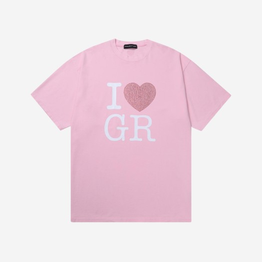
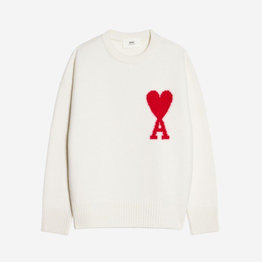
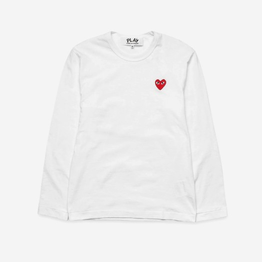
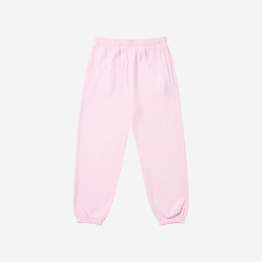
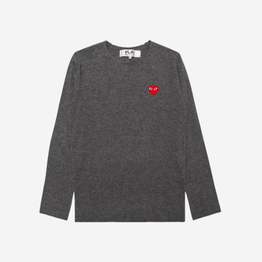





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'OpenAIEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('a52f4945-86e3-48f4-be35-a0ac21dd8f72'),
 'run_id': UUID('ccf13f9e-741b-4b55-a2cc-fd4af7896435'),
 'tags': ['seq:step:2', 'text']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('a52f4945-86e3-48f4-be35-a0ac21dd8f72'),
 'run_id': UUID('ccf13f9e-741b-4b55-a2cc-fd4af7896435'),
 'tags': ['seq:step:2', 'text']}



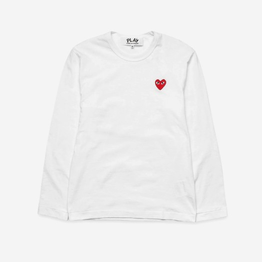
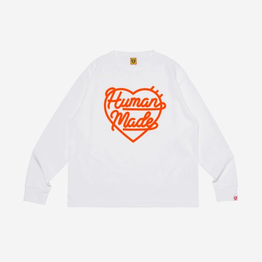
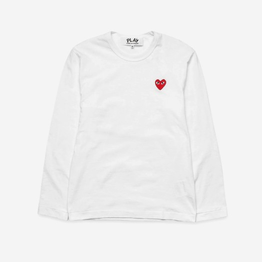
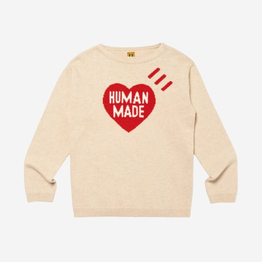
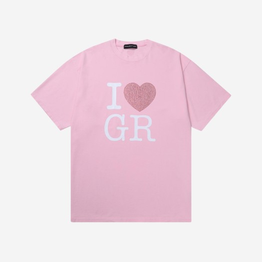





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'OpenAIEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('06696052-5ed8-41a1-bd66-8b2424d0a4a8'),
 'run_id': UUID('3b0208b9-fbd8-47d8-a920-cd59ba06c3a1'),
 'tags': ['seq:step:1', 'hybrid']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('06696052-5ed8-41a1-bd66-8b2424d0a4a8'),
 'run_id': UUID('3b0208b9-fbd8-47d8-a920-cd59ba06c3a1'),
 'tags': ['seq:step:1', 'hybrid']}



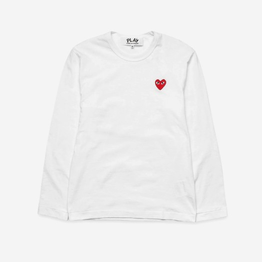
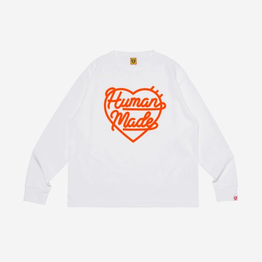
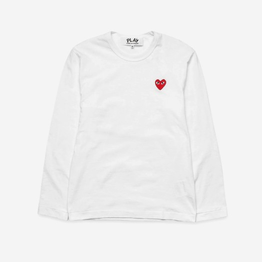
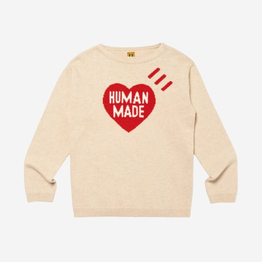
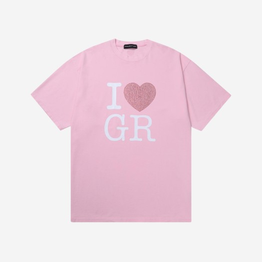

In [59]:
for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        "pink top with heart shape logo",
        {"callbacks": [LoggingCallbackHandler(show_metadata=True)]},
    )
    print("\n")
    print("\n")

[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



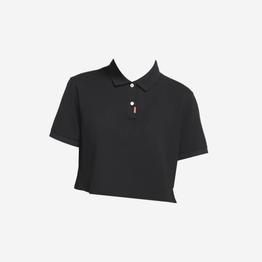
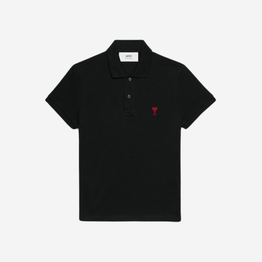
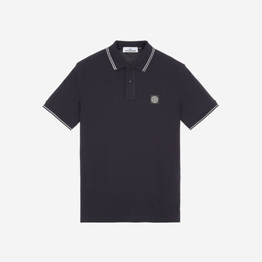
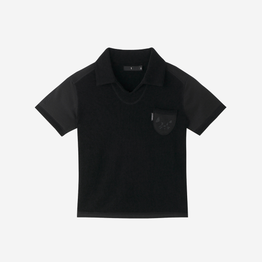
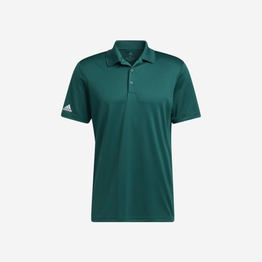





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



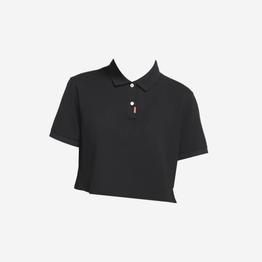
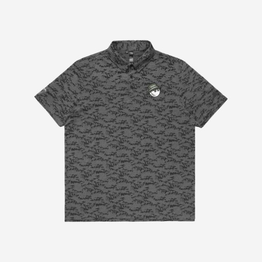
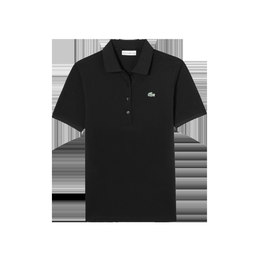
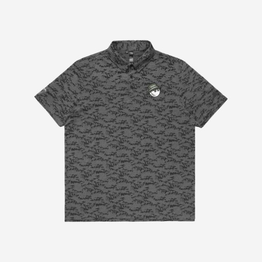
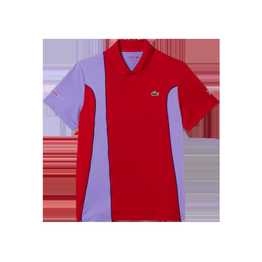





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



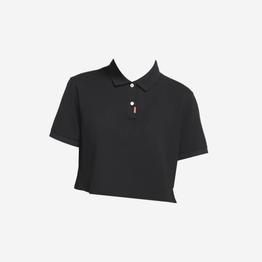
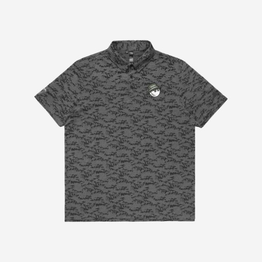
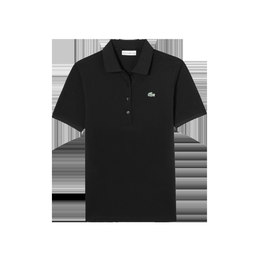
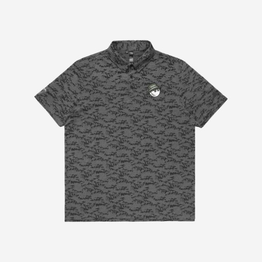
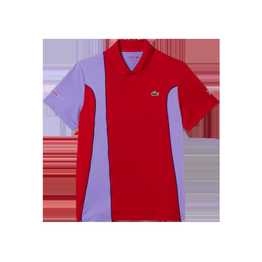

In [60]:
for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        "polo shirt",
        {"callbacks": [LoggingCallbackHandler()]},
    )
    print("\n")
    print("\n")

True
False
[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========


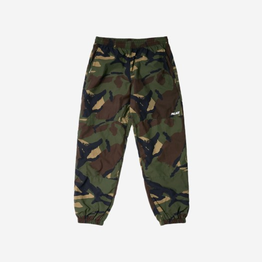

========== Retrieving Result ==========



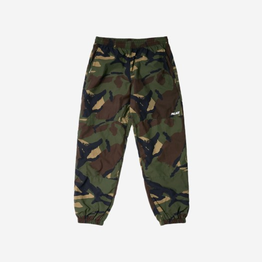
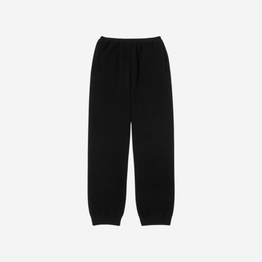
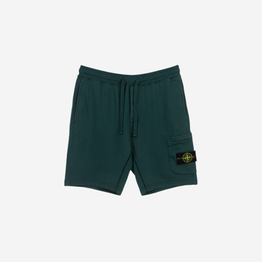
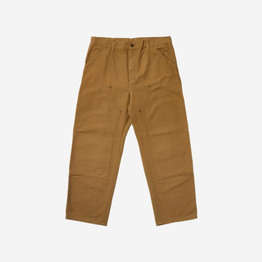
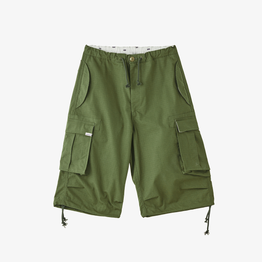





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
These are camouflage jogger pants. They feature an elastic waistband and cuffs, offering a comfortable and adjustable fit. The pants have a classic camo pattern in shades of green, brown, and black, which is often used for a casual or sporty look. They may also include pockets for added functionality.
========== Retrieving Result ==========



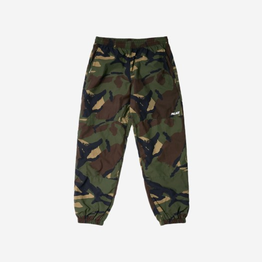
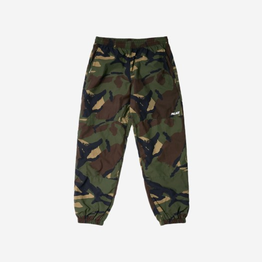
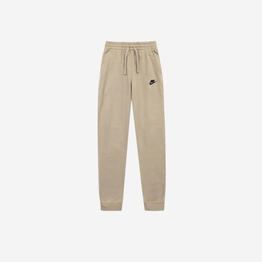
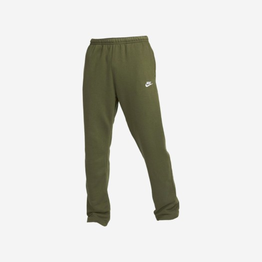
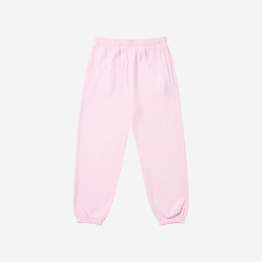





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========


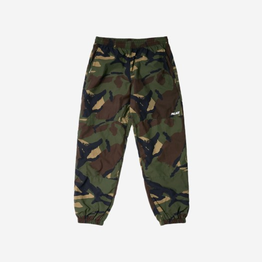

========== Retrieving Result ==========



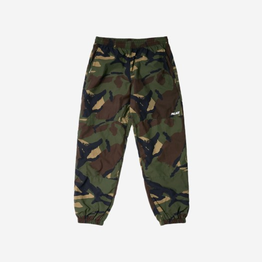
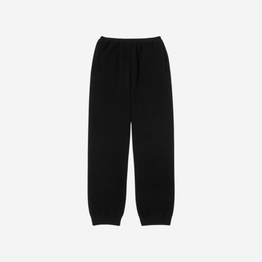
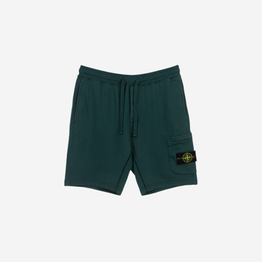
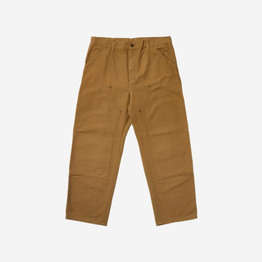
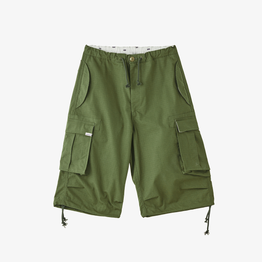

In [61]:
# Use `base64_image` for embedding NOT `base64_image_url`
print(is_base64(database[174]["base64_image"]))
print(is_base64(database[174]["base64_image_url"]))


for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        database[174]["base64_image"],
        {"callbacks": [LoggingCallbackHandler()]},
    )
    print("\n")
    print("\n")

[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========


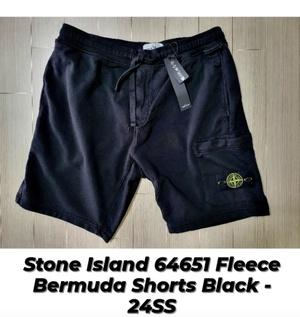

========== Retrieving Result ==========



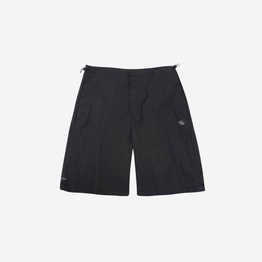
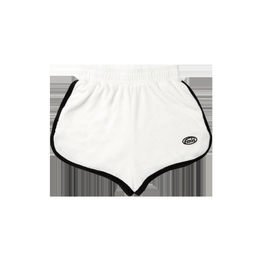
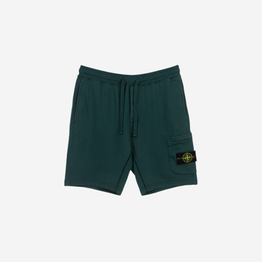
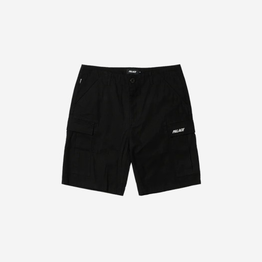
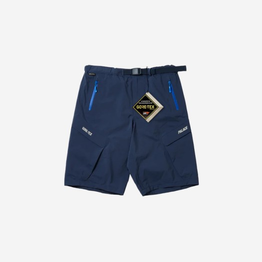





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
These are black fleece Bermuda shorts from Stone Island, style number 64651. They feature an elastic waistband with a drawstring for adjustable comfort. The shorts have a casual design with a pocket on the side, adorned with the Stone Island compass logo patch, adding a distinctive brand touch. They are likely made from a soft fleece material, ideal for a comfortable and stylish casual look.
========== Retrieving Result ==========



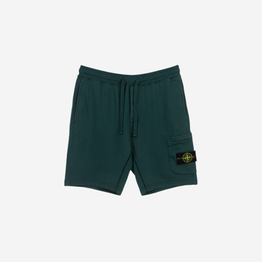
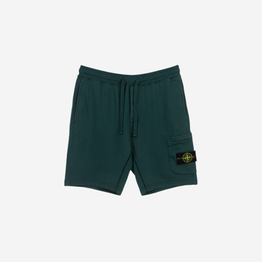
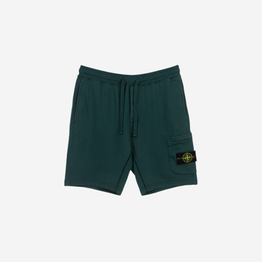
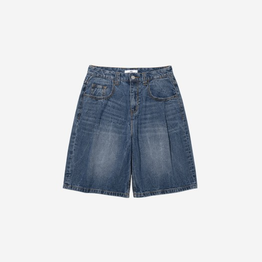
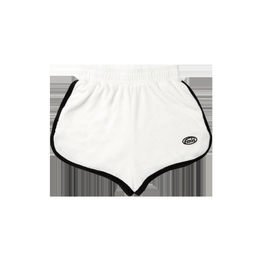





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========


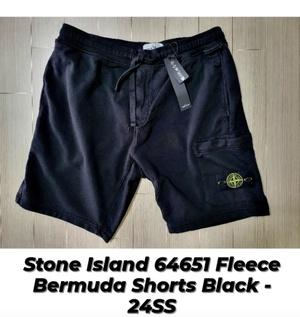

========== Retrieving Result ==========



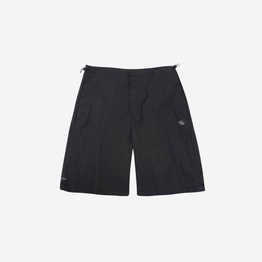
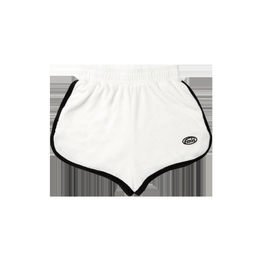
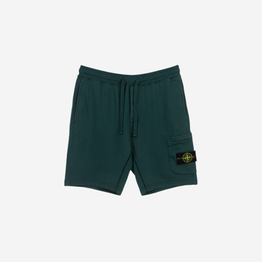
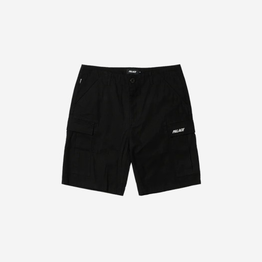
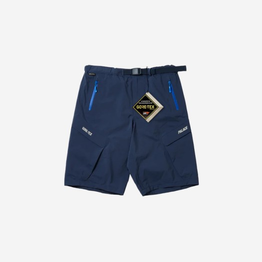





[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========


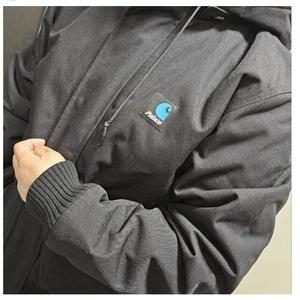

========== Retrieving Result ==========



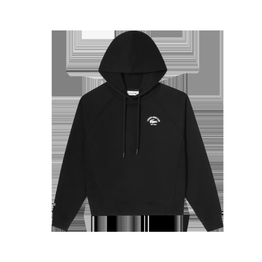
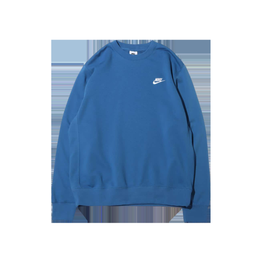
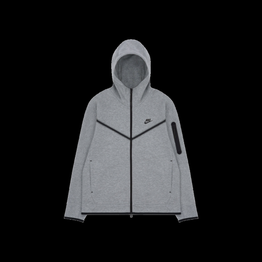
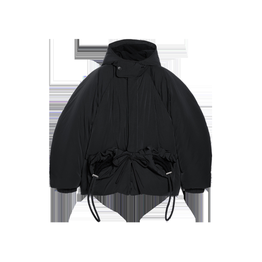
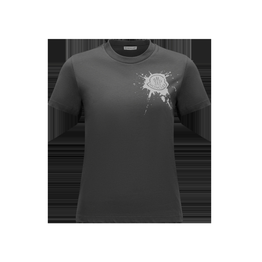





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
This image shows a person wearing a dark-colored, hooded jacket. The jacket appears to be made of a sturdy, possibly water-resistant material. It has a zip-up front, ribbed cuffs, and a logo on the chest. The design suggests it is suitable for colder weather, providing warmth and protection against the elements.
========== Retrieving Result ==========



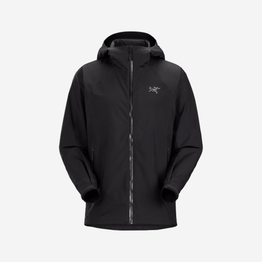
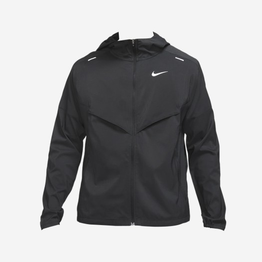
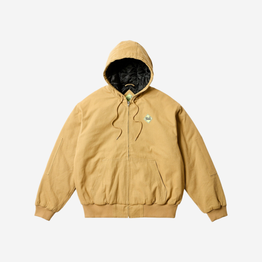
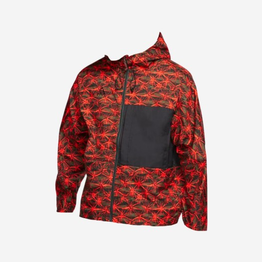
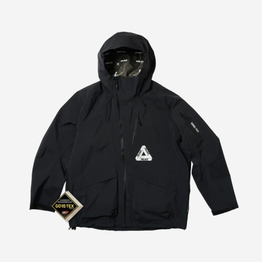





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========


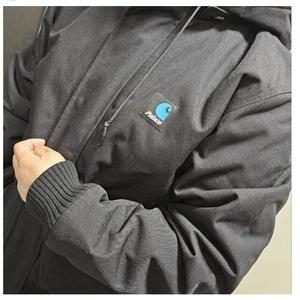

========== Retrieving Result ==========



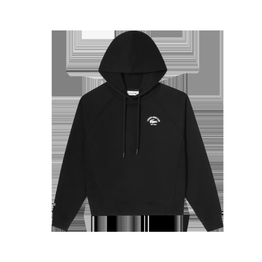
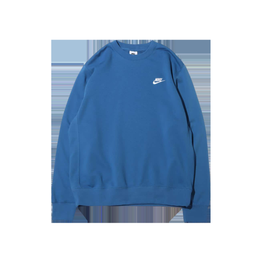
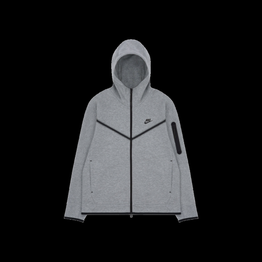
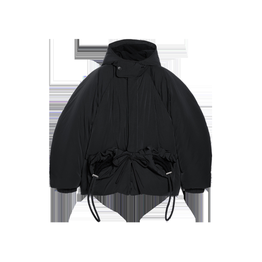
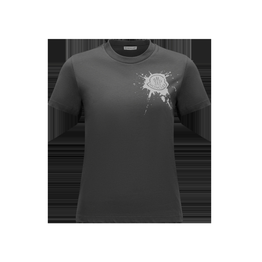





[ Multimodal Retriever ]
type : multimodal
========== Retrieving Query ==========


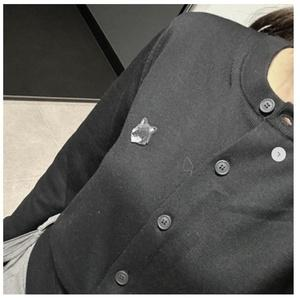

========== Retrieving Result ==========



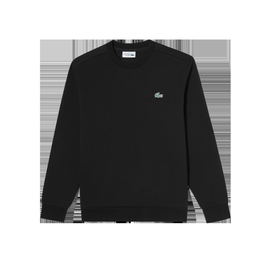
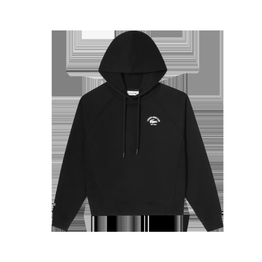
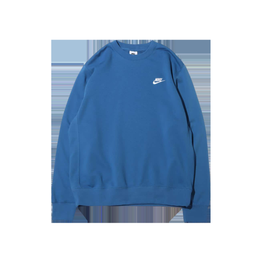
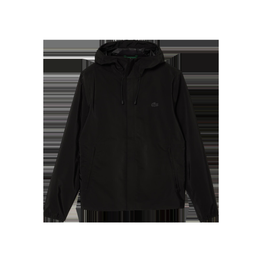
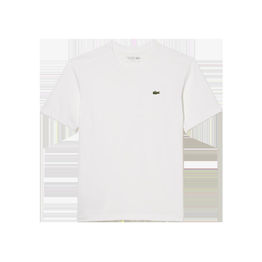





[ Text Embedding Retriever ]
type : text
========== Retrieving Query ==========
The image shows a black button-up cardigan. It has a round neckline and features a small, shiny embellishment on the chest, possibly a brooch or decorative pin. The cardigan appears to be made from a knit material, suitable for layering in cooler weather.
========== Retrieving Result ==========



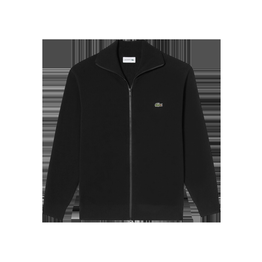
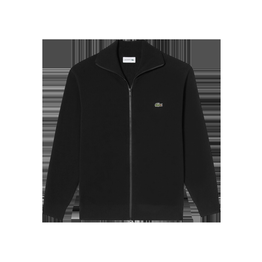
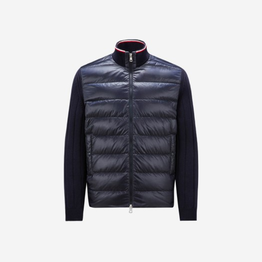
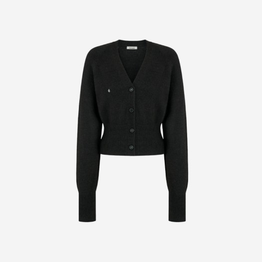
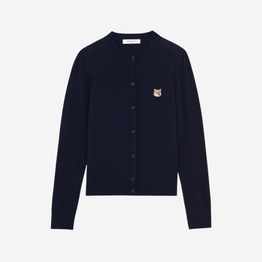





[ Hybrid Retriever ]
type : hybrid
========== Retrieving Query ==========


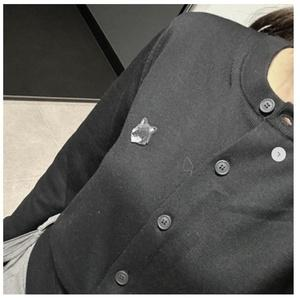

========== Retrieving Result ==========



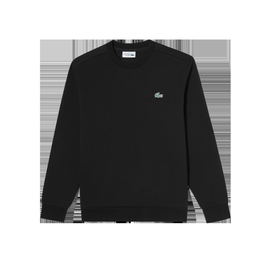
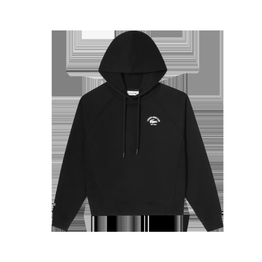
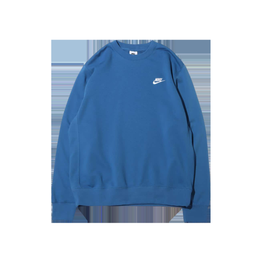
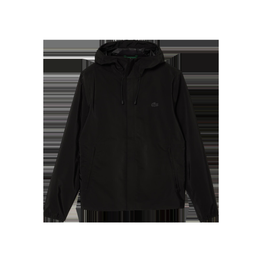
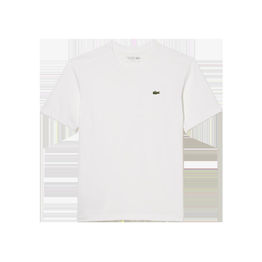

In [152]:
def encode_image_base64_from_file(file_path):
    try:
        with open(file_path, "rb") as img_file:
            image_data = img_file.read()

        image = Image.open(BytesIO(image_data))
        max_size = (2000, 2000)
        image.thumbnail(max_size, Image.Resampling.LANCZOS)

        buffer = BytesIO()
        image.convert("RGB").save(buffer, format="JPEG")
        resized_image_data = buffer.getvalue()

        encoded_image = base64.b64encode(resized_image_data)
        decoded_image = encoded_image.decode("utf8")
        return decoded_image
    except Exception as e:
        print(e)
    return None


for root, dirs, files in os.walk("../assets"):
    for file in files:
        if (
            any(file.lower().endswith(ext) for ext in [".jpeg", ".jpg", ".png"])
            and file.startswith("11-ShoppingQnA")
            and file.split("-")[2].split(".")[0] in ["01", "02", "03"]
        ):
            image = encode_image_base64_from_file(file_path=os.path.join(root, file))
            for name, retriever in retrievers:
                print(f"[ {name} ]")
                retriever.invoke(
                    image,
                    {"callbacks": [LoggingCallbackHandler()]},
                )
                print("\n")
                print("\n")

## Multimodal RAG Chatbot


In [229]:
# Setup Configurable Retriever
from langchain_core.runnables.utils import ConfigurableField


retriever = multimodal_retriever.configurable_alternatives(
    ConfigurableField(id="retriever"),
    default_key="multimodal",
    text=text_embedding_retriever,
    hybrid=hybrid_retriever,
)

In [230]:
# Setup Message History
from langchain_core.chat_history import BaseChatMessageHistory
from typing import List
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage


class InMemoryHistory(BaseChatMessageHistory, BaseModel):
    """In memory implementation of chat message history."""

    messages: List[BaseMessage] = Field(default_factory=list)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add a list of messages to the store"""
        self.messages.extend(messages)

    def clear(self) -> None:
        self.messages = []


store = {}


def get_session_history(user_id: str, conversation_id: str) -> BaseChatMessageHistory:
    if (user_id, conversation_id) not in store:
        store[(user_id, conversation_id)] = InMemoryHistory()
    return store[(user_id, conversation_id)]

In [231]:
# Setup Prompt
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

one_shot_prompt = [
    ("user", "Can you recommend some jackets suitable for outdoor activities?"),
    (
        "assistant",
        "Here are three jackets based on the search results that are suitable for outdoor activities:\n"
        "\n"
        "[89]: Arc'teryx Kadin Hoody Black\n"
        "- This sleek black hooded jacket is crafted from weather-resistant material, ensuring you stay dry and comfortable during outdoor adventures.\n"
        "- Its subtle logo adds a touch of premium branding without being overly noticeable.\n"
        "- The weather-resistant material makes it ideal for outdoor activities in unpredictable weather.\n"
        "- The minimalist design ensures it pairs well with various outfits, making it versatile for different settings.\n"
        "\n"
        "[26]: Patagonia Torrentshell Jacket\n"
        "- This lightweight and waterproof jacket is perfect for hiking and outdoor exploration in rainy conditions.\n"
        "- Made from recycled materials, it is an eco-friendly choice that doesn't compromise on durability or performance.\n"
        "- Its lightweight design makes it easy to pack for hikes or trips.\n"
        "- The waterproof feature ensures you stay dry even in heavy rain, and the use of recycled materials supports sustainability.\n"
        "\n"
        "if you have any further questions or need more specific recommendations, feel free to ask! I'm here to help you find the perfect jacket for your needs.",
    ),
]

main_prompt = [
    (
        "system",
        "Human would like to find fashion products, and you recommend fashion products that users want through conversations and question using only information from the search results.\n"
        "If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question.\n"
        "\n"
        "Here are the instructions:\n"
        "1. Analyze the user's query to understand the context and required information.\n"
        "2. Generate a detailed and accurate response based on the provided sources.\n"
        "3. For each sentence in the response, explain why you recommend the product. Use the format\n"
        "[id]:productDisplayName\n"
        "4. Ensure the response is coherent and logically structured.\n"
        "\n"
        "Here is the search result:\n"
        "{context}"
        "\n"
        "DO NOT FORGET [id]:productDisplayName FORMAT ON RECOMMENDATION\n"
        "DO NOT FORGET [id]:productDisplayName FORMAT ON RESPONSE\n",
    ),
    MessagesPlaceholder(variable_name="history"),
    ("user", "{question}"),
]

prompt = ChatPromptTemplate.from_messages(
    [
        *one_shot_prompt,
        *main_prompt,
        HumanMessage(
            content=[
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                },
            ],
        ),
    ]
).configurable_alternatives(
    ConfigurableField(id="prompt"),
    default_key="question_and_image",
    question=ChatPromptTemplate.from_messages(
        [
            *one_shot_prompt,
            *main_prompt,
        ]
    ),
)

In [232]:
from langchain_core.runnables import ConfigurableFieldSpec
from langchain_core.runnables.history import RunnableWithMessageHistory

generation_chain = prompt | llm_multimodal

generate_with_history = RunnableWithMessageHistory(
    generation_chain,
    get_session_history=get_session_history,
    input_messages_key="question",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="user_id",
            annotation=str,
            name="User ID",
            description="Unique identifier for the user.",
            default="",
            is_shared=True,
        ),
        ConfigurableFieldSpec(
            id="conversation_id",
            annotation=str,
            name="Conversation ID",
            description="Unique identifier for the conversation.",
            default="",
            is_shared=True,
        ),
    ],
)

In [233]:
chatbot = (
    RunnableBranch(
        (
            lambda x: isinstance(x, str),
            {
                "question": RunnablePassthrough(),
                "context": retriever,
            },
        ),
        {
            "question": RunnableLambda(lambda x: x["question"]),
            "image": RunnableLambda(lambda x: x["image"]),
            "context": RunnableParallel(
                {
                    "from_question": (lambda x: x["question"]) | retriever,
                    "from_image": (lambda x: x["image"]) | retriever,
                }
            )
            | RunnableLambda(lambda x: [*x["from_question"], *x["from_image"]]),
        },
    )
    | generate_with_history
    | StrOutputParser().with_config({"tags": ["chatbot"]})
)

type : text
========== Retrieving Query ==========
Can you recommend a black jacket that is good for city walks?
========== Retrieving Result ==========



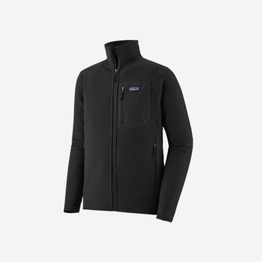
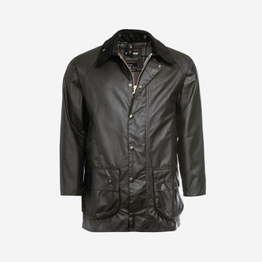
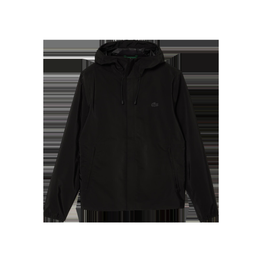
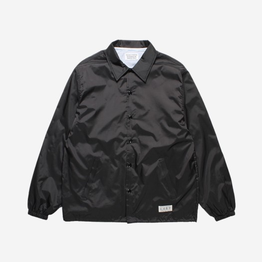
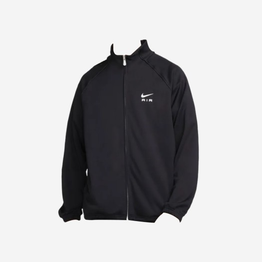

========== Chatbot Response ==========
Certainly! Here are some great options for black jackets suitable for city walks:

[80]: **Barbour Beaufort Wax Jacket Black**  
- This jacket offers a timeless design with its smooth, waxed texture, making it perfect for city walks where style is important.  
- Its weather-resistant fabric and large front pockets combine practicality with elegance, allowing you to comfortably carry essentials.  
- The button-up front and high collar provide both style and protection against the elements.  

[45]: **Lacoste Active Hoodie Short Jacket Black**  
- This jacket combines sleek style with comfort, featuring a modern design that's perfect for casual city strolls.  
- The front zipper and elastic cuffs ensure a snug fit, keeping you cozy during brisk walks.  
- Its versatile design makes it easy to pair with various outfits, enhancing your urban look.  

[88]: **Wacko Maria Coach Jacket Black**  
- Known for its sleek and casual design, this jacket is a g


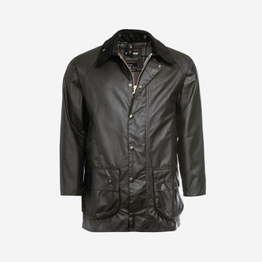
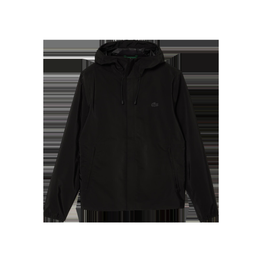
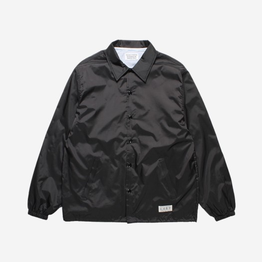

In [234]:
response = chatbot.invoke(
    "Can you recommend a black jacket that is good for city walks?",
    # invoke of RunnableBindingBase can send a configs
    config={
        "configurable": {
            "user_id": "123",
            "conversation_id": "1",
            # Choose what retriever you want to use : "multimodal", "text", "hybrid"
            "retriever": "text",
            "prompt": "question",
        },
        "callbacks": [LoggingCallbackHandler()],
    },
)

type : text
========== Retrieving Query ==========
what did you recommend?
========== Retrieving Result ==========



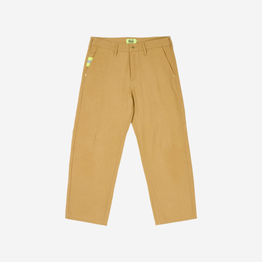
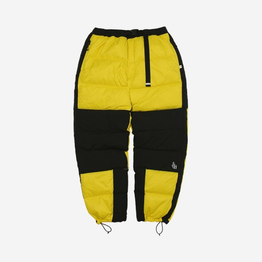
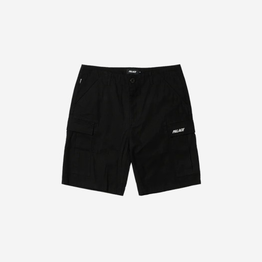
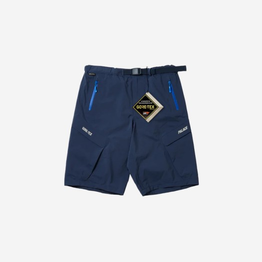
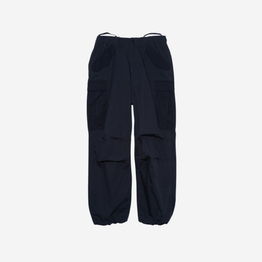

========== Chatbot Response ==========
I apologize for the confusion. It seems I mistakenly provided recommendations not based on the data available. Unfortunately, the search results do not include any black jackets suitable for city walks. If you have any other specific preferences or need further assistance, feel free to ask!


========== Recommend Products ==========
No products to Recommend




In [235]:
response = chatbot.invoke(
    "what did you recommend?",
    config={
        "configurable": {
            "user_id": "123",
            "conversation_id": "1",
            "retriever": "text",
            "prompt": "question",
        },
        "callbacks": [LoggingCallbackHandler()],
    },
)

type : hybridtype : hybrid
========== Retrieving Query ==========

========== Retrieving Query ==========
Can you recommend a few products similar to the jacket in this photo?


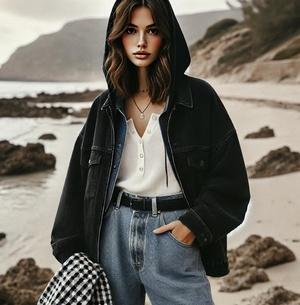

========== Retrieving Result ==========



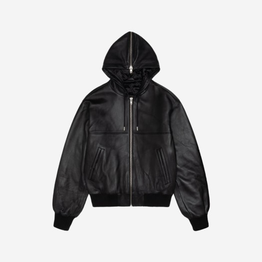
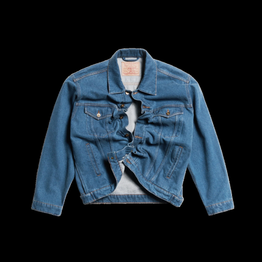
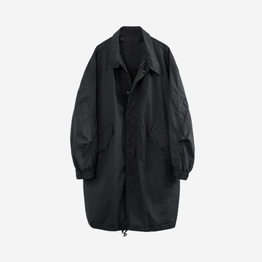
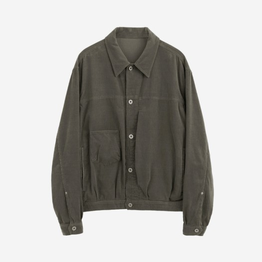
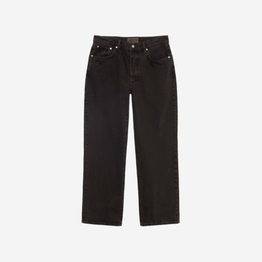

========== Retrieving Result ==========



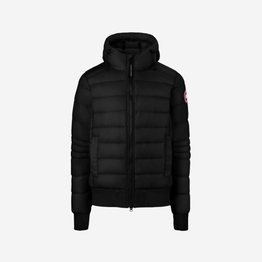
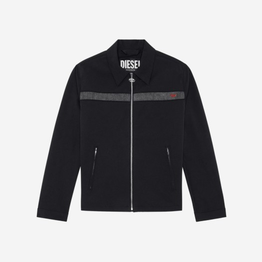
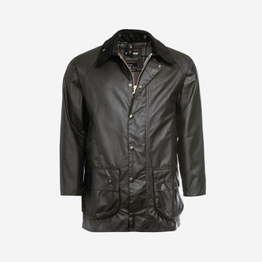
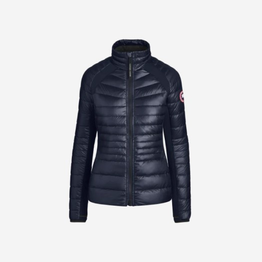
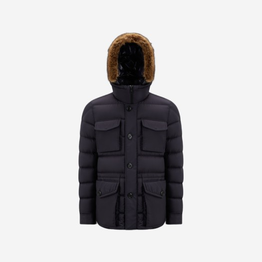

========== Chatbot Response ==========
I'm unable to view the image to identify specific details. However, if you're looking for a black button-up jacket with a simple design, you might consider these options:

[80]: **Barbour Beaufort Wax Jacket Black**
- A classic black wax jacket with a button-up front and high collar, perfect for a timeless look.

[149]: **Polyteru Corduroy Trucker Jacket Olive Gray**
- While this is in olive gray, it offers a similar button-up style with a textured feel.

If you can provide more details about the style or features, I can offer more tailored recommendations!


========== Recommend Products ==========



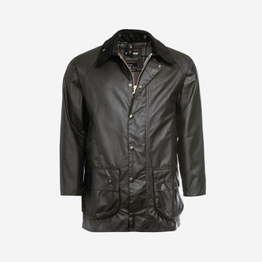
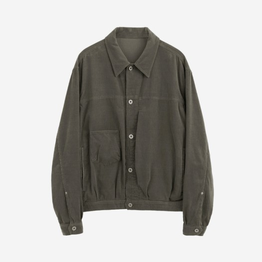

In [236]:
response = chatbot.invoke(
    {
        "image": encode_image_base64_from_file("../assets/11-ShoppingQnA-04.jpg"),
        "question": "Can you recommend a few products similar to the jacket in this photo?",
    },
    config={
        "configurable": {
            "user_id": "123",
            "conversation_id": "1",
            "retriever": "hybrid",
        },
        "callbacks": [LoggingCallbackHandler()],
    },
)